In [2]:
with open("input.txt", "r") as file:
    data = file.read()
    data = data.splitlines()


In [3]:
example_data = [
    ".......S.......",
    "...............",
    ".......^.......",
    "...............",
    "......^.^......",
    "...............",
    ".....^.^.^.....",
    "...............",
    "....^.^...^....",
    "...............",
    "...^.^...^.^...",
    "...............",
    "..^...^.....^..",
    "...............",
    ".^.^.^.^.^...^.",
    "...............",
]


## Part 1

In [4]:

def count_splits(data) -> int:
    splits = []
    start = [i for i in range(len(data[0])) if data[0][i] == "S"][0] # Get starting ray
    rays = set() # Active rays, overlapping rays only stored once
    rays.add(start)
    get_idx_of_splits = lambda line: [i for i, elem in enumerate(line) if elem == "^"] # noqa: E731
    data = [line for line in data if line != "." * len(line)] # remove "empty" lines
    for line in data[1:]:
        split_idx = get_idx_of_splits(line) # Get indices of splits in this line
        intersection = rays.intersection(split_idx) # Find intersections with current rays
        if intersection: # If there are intersections
            splits.extend(intersection) # Add to splits
            for idx in intersection:
                rays.remove(idx) # Remove the hits
                # Add new rays to the left and right
                rays.add(idx - 1) 
                rays.add(idx + 1)
    return len(splits)

print(count_splits(data))




1537


## Part 2

In [5]:
def count_timelines(data) -> int:
    """ Counts the number of paths (timelines) to end states. (Plinko algorithm) """
    start = [i for i in range(len(data[0])) if data[0][i] == "S"][0]  # Get starting ray
    rays = set()  # Active rays, overlapping rays only stored once
    rays.add(start)
    get_idx_of_splits = lambda line: [i for i, elem in enumerate(line) if elem == "^"]  # noqa: E731
    data = [line for line in data if line != "." * len(line)]
    paths = [0] * len(data[0])  # Paths to each index
    paths[start] = 1  # One path to starting ray

    for line in data[1:]:
        split_idx = get_idx_of_splits(line)  # Get indexes of splits in this line
        intersection = rays.intersection(split_idx)  # Find intersections with current rays
        if intersection:  # If there are intersections (rays that split)
            for idx in intersection:
                
                # Update paths for new rays to the left and right
                paths[idx - 1] += paths[idx]
                paths[idx + 1] += paths[idx]
                paths[idx] = 0  # Clear paths at the split index
                # Add new rays to the left and right
                rays.add(idx - 1)
                rays.add(idx + 1)
                rays.remove(idx)  # Remove the ray that splits

    return sum(paths)
                

print(count_timelines(example_data)) # Should be 40
#print(count_timelines(data))

40


## Visualize the path map

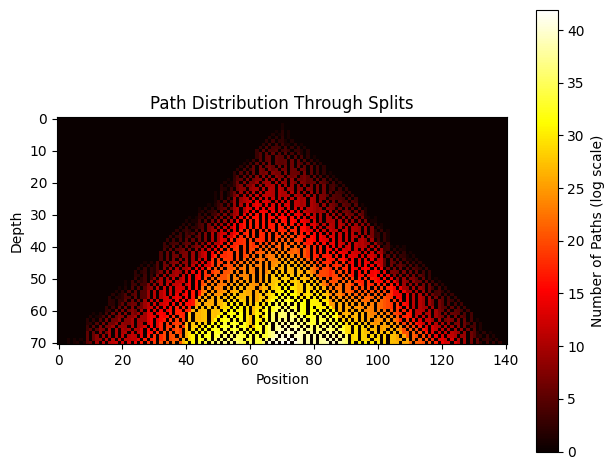

In [6]:
import matplotlib.pyplot as plt
import numpy as np
def plot_paths(data):
    start = [i for i in range(len(data[0])) if data[0][i] == "S"][0]  # Get starting ray
    rays = set()  # Active rays, overlapping rays only stored once
    rays.add(start)
    get_idx_of_splits = lambda line: [i for i, elem in enumerate(line) if elem == "^"]  # noqa: E731
    data = [line for line in data if line != "." * len(line)]
    paths = [0] * len(data[0])  # Paths to each index
    paths[start] = 1  # One path to starting ray

    path_history = []
    path_history.append(paths.copy())

    for line in data[1:]:
        split_idx = get_idx_of_splits(line)  # Get indexes of splits in this line
        intersection = rays.intersection(split_idx)  # Find intersections with current rays
        if intersection:  # If there are intersections (rays that split)
            for idx in intersection:
                
                # Update paths for new rays to the left and right
                paths[idx - 1] += paths[idx]
                paths[idx + 1] += paths[idx]
                paths[idx] = 0  # Clear paths at the split index
                # Add new rays to the left and right
                rays.add(idx - 1)
                rays.add(idx + 1)
                rays.remove(idx)  # Remove the ray that splits
        path_history.append(paths.copy())
    
    path_history = np.array(path_history)
    path_history[path_history == 0] = 1  # Avoid log(0) by setting 0s to 1s for visualization
    # to log scale
    path_history = np.log2(path_history)
    plt.imshow(path_history, cmap='hot', interpolation='nearest')
    plt.colorbar(label='Number of Paths (log scale)')
    plt.xlabel('Position')
    plt.ylabel('Depth')
    plt.title('Path Distribution Through Splits')
    plt.tight_layout()
    plt.savefig('path_distribution.png')
    
    plt.show()
    
plot_paths(data)


In [ ]:
from matplotlib import animation as anim

def animate_paths(data):
    frames = []
    start = [i for i in range(len(data[0])) if data[0][i] == "S"][0]  # Get starting ray
    rays = set()  # Active rays, overlapping rays only stored once
    rays.add(start)
    get_idx_of_splits = lambda line: [i for i, elem in enumerate(line) if elem == "^"]  # noqa: E731
    data = [line for line in data if line != "." * len(line)]  # remove "empty" lines

    frame = np.zeros((len(data), len(data[0])))  # Frame to hold path counts
    paths = [0] * len(data[0])  # Paths to each index
    paths[start] = 1  # One path to starting ray
    frame[0, start] = paths[start]
    for i,line in enumerate(data[1:], start=1):
        split_idx = get_idx_of_splits(line)  # Get indexes of splits in this line
        intersection = rays.intersection(split_idx)  # Find intersections with current rays
        if intersection:  # If there are intersections (rays that split)
            for idx in intersection:
                # Update paths for new rays to the left and right
                paths[idx - 1] += paths[idx]
                paths[idx + 1] += paths[idx]
                paths[idx] = 0  # Clear paths at the split index
                # Add new rays to the left and right
                rays.add(idx - 1)
                rays.add(idx + 1)
                rays.remove(idx)  # Remove the ray that splits
        frame[i] = paths
        frames.append(frame.copy())
    frames = np.log2(np.array(frames) + 1)  # to log scale, add 1 to avoid log(0)
    fig, ax = plt.subplots()
    im = ax.imshow(frames[0], cmap='hot', interpolation='nearest', vmin=0, vmax=np.max(frames))
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('Number of Paths')
    ax.set_xlabel('Position')
    ax.set_ylabel('Depth')
    ax.set_title('Path Distribution Through Splits')
    plt.tight_layout()
    plt.close()  # Prevents extra static plot display

    def update(frame):
        im.set_array(frame)
        return [im]

    ani = anim.FuncAnimation(fig, update, frames=frames, blit=True, interval=50)

    return ani

ani = animate_paths(example_data)
ani.save('example_path_animation.gif', writer='pillow')

ani = animate_paths(data)
ani.save('path_animation.gif', writer='pillow')
        


![path animation](./path_animation.gif)